In [74]:
import tensorflow as tf
print("Tensorflow imported")
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

Tensorflow imported


In [76]:
data = tf.keras.utils.image_dataset_from_directory('data/dataset/',image_size=(60,40),color_mode="grayscale")
data_iter = data.as_numpy_iterator()
data_iter

Found 210227 files belonging to 62 classes.


In [50]:
batch = data_iter.next()

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'Y' 'a' 'e'
 'f' 'g' 'm' 'n' 'p' 'r' 't' 'u']


In [78]:
batch = data_iter.next()
print(len(batch),batch[1],batch[0].shape)
print(data.class_names)
class_names = data.class_names

2 [34 32 36 10 25 32 38 61  8 31 12 57  3 41 13 57 43 25 15 61 44 53 54 46
 20 24 31  6 44  6 50 17] (32, 60, 40, 1)
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A_U', 'B_U', 'C_U', 'D_U', 'E_U', 'F_U', 'G_U', 'H_U', 'I_U', 'J_U', 'K_U', 'L_U', 'M_U', 'N_U', 'O_U', 'P_U', 'Q_U', 'R_U', 'S_U', 'T_U', 'U_U', 'V_U', 'W_U', 'X_U', 'Y_U', 'Z_U', 'a_L', 'b_L', 'c_L', 'd_L', 'e_L', 'f_L', 'g_L', 'h_L', 'i_L', 'j_L', 'k_L', 'l_L', 'm_L', 'n_L', 'o_L', 'p_L', 'q_L', 'r_L', 's_L', 't_L', 'u_L', 'v_L', 'w_L', 'x_L', 'y_L', 'z_L']


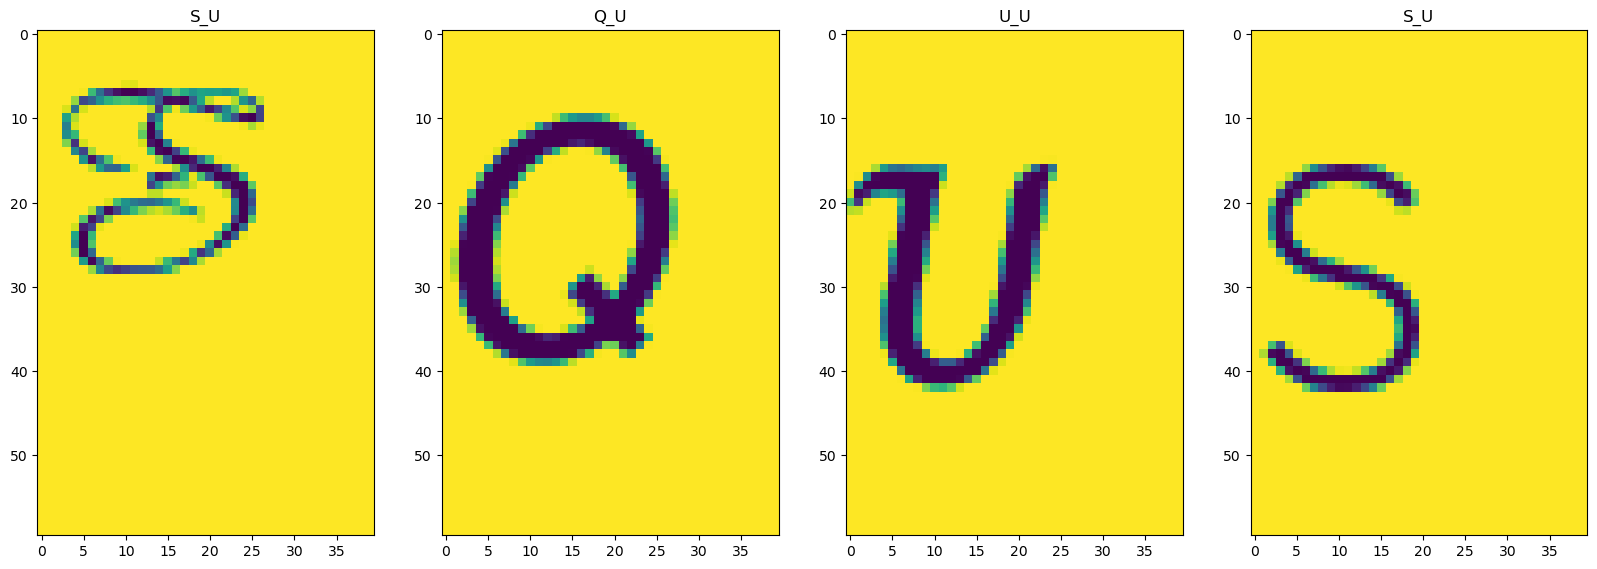

In [80]:
fig, ax = plt.subplots(1,4)
'''
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].set_title(class_names[batch[1][idx]])
'''

# Alternate way to view plots from tensorflow docs
for images, labels in data.take(1):
    for i in range(4):
        ax[i].imshow(images[i].numpy().astype(int))
        ax[i].set_title(class_names[labels[i]])
#print(img.shape)
# plt.imshow(img)

In [81]:
data = data.map(lambda x,y:(x/255,y))

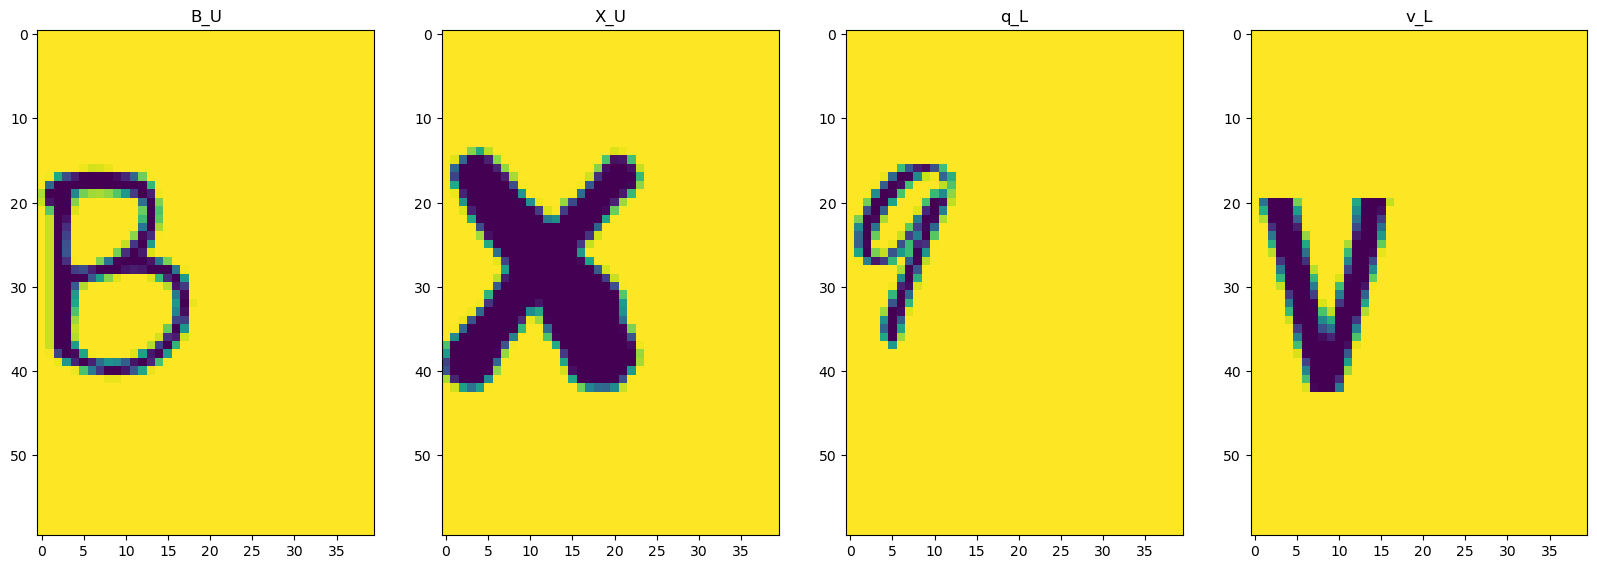

In [82]:
fig, ax = plt.subplots(1,4)
for images, labels in data.take(1):
    for i in range(4):
        ax[i].imshow(images[i].numpy())
        ax[i].set_title(class_names[labels[i]])
plt.show()

In [84]:
data_iter_val = data.as_numpy_iterator()
batch = data_iter_val.next()
print(batch[1])
batch[0].shape

[ 9 27 44 36 45 51 59  9 22 59 43 28 19  1  4 32 15 25 30  9 21 18  5  4
 55 38 13 15 48 26 43 36]


(32, 60, 40, 1)

In [85]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)
print(f"Training dataset size: {train_size}\nVal. dataset size: {val_size}\nTest dataset size: {test_size}\nTotal: {len(data)}")
print(f"Total size after splitting: {train_size+test_size+val_size}")
print(f"Was the split right: {train_size+test_size+val_size==len(data)}")

Training dataset size: 4599
Val. dataset size: 1314
Test dataset size: 657
Total: 6570
Total size after splitting: 6570
Was the split right: True


In [86]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential([
  Conv2D(32, 3, activation='relu', input_shape=(60,40,1),padding="same"), # padding is applied
    # Each filter is of dimension 3,3,1 
  AveragePooling2D(pool_size=(2,2)), # The maximum value of 2x2 sub-matrix is taken
  
  Conv2D(32, 3, activation='relu'),
  AveragePooling2D(pool_size=2, padding="valid"),

  Conv2D(32, 3, activation='relu'),
  AveragePooling2D(pool_size=2, padding="valid"),
  
  Flatten(),
  Dense(62, activation='softmax') # changed to have 62 neurons (same as number of classes) and 'softmax' activation
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 60, 40, 32)        320       
                                                                 
 average_pooling2d_3 (Avera  (None, 30, 20, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 18, 32)        9248      
                                                                 
 average_pooling2d_4 (Avera  (None, 14, 9, 32)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_19 (Conv2D)          (None, 12, 7, 32)         9248      
                                                                 
 average_pooling2d_5 (Avera  (None, 6, 3, 32)         

In [89]:
# Define a Callback class that stops training once accuracy reaches 90%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.90):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse categorical entropy in case of softmax acti. func.
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [90]:
#Fit the model
history = model.fit(train,
                    epochs=10,
                    steps_per_epoch=len(train),
                    validation_data=val,
                    callbacks=[ModelCheckpoint("./models/checkpoints_new/{epoch:02d}.h5",save_best_only=True),
                               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

Epoch 1/10
4599/4599 [==============================] - 34s 7ms/step - loss: 1.0329 - accuracy: 0.7573 - val_loss: 0.6406 - val_accuracy: 0.8412
Epoch 2/10
  21/4599 [..............................] - ETA: 23s - loss: 0.6044 - accuracy: 0.8482

/home/msi/miniconda3/envs/tf_cuda/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4599/4599 [==============================] - 31s 7ms/step - loss: 0.5586 - accuracy: 0.8595 - val_loss: 0.5140 - val_accuracy: 0.8687
Epoch 3/10
4599/4599 [==============================] - 32s 7ms/step - loss: 0.4594 - accuracy: 0.8805 - val_loss: 0.4506 - val_accuracy: 0.8835
Epoch 4/10
4599/4599 [==============================] - 32s 7ms/step - loss: 0.4058 - accuracy: 0.8918 - val_loss: 0.4179 - val_accuracy: 0.8893
Epoch 5/10
4599/4599 [==============================] - 32s 7ms/step - loss: 0.3711 - accuracy: 0.8996 - val_loss: 0.4214 - val_accuracy: 0.8880
Epoch 6/10
4599/4599 [==============================] - 32s 7ms/step - loss: 0.3460 - accuracy: 0.9052 - val_loss: 0.3998 - val_accuracy: 0.8944
Epoch 7/10
4599/4599 [==============================] - 31s 7ms/step - loss: 0.3277 - accuracy: 0.9094 - val_loss: 0.3901 - val_accuracy: 0.8955
Epoch 8/10
4599/4599 [==============================] - 38s 8ms/step - loss: 0.3124 - accuracy: 0.9129 - val_loss: 0.3858 - val_accuracy: 0.8

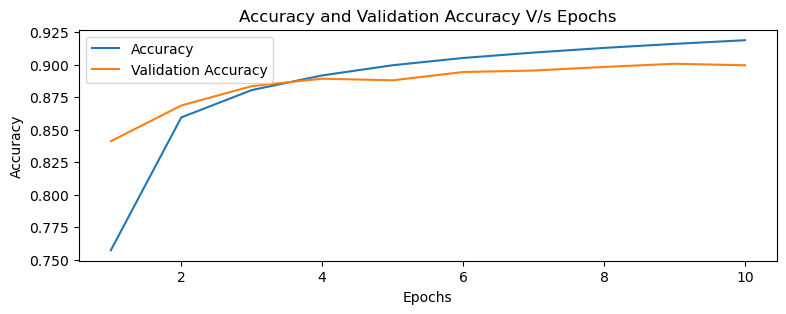

In [96]:
epochs = [*range(1,11)]
fig, ax = plt.subplots(1,1,figsize=(9,3))
ax.plot(epochs,history.history["accuracy"])
ax.plot(epochs,history.history["val_accuracy"])
ax.legend(["Accuracy","Validation Accuracy"])
ax.set_title("Accuracy and Validation Accuracy V/s Epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.savefig("models/model_perf/acc_plt.png",dpi=400)
plt.show(); plt.close()

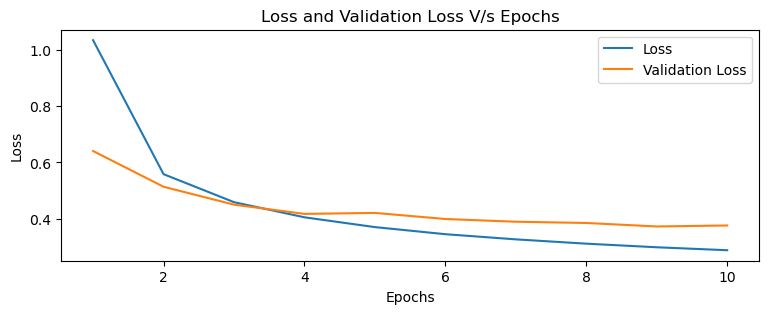

In [97]:
fig, ax = plt.subplots(1,1,figsize=(9,3))
ax.plot(epochs,history.history["loss"])
ax.plot(epochs,history.history["val_loss"])
ax.legend(["Loss","Validation Loss"])
ax.set_title("Loss and Validation Loss V/s Epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.savefig("./models/model_perf/loss_plt.png",dpi=400)
plt.show(); plt.close()

In [98]:
from tensorflow.keras.models import load_model
loaded_model = load_model("models/checkpoints_new/09.h5")
eval_data = loaded_model.evaluate(test)
print(eval_data)

657/657 [==============================] - 12s 4ms/step - loss: 0.3677 - accuracy: 0.9028
[0.36773478984832764, 0.9028128385543823]


In [99]:
# data_iter_val = test.as_numpy_iterator()
# test_batch = data_iter_val.next()
# print(test_batch)
predictions = np.array([])
labels = np.array([])

for x,y in test:
    predictions = np.concatenate([predictions,np.argmax(loaded_model.predict(x),axis=-1)])
    labels = np.concatenate([labels,y.numpy()])

#     print(y.numpy())
#     labels =  np.concatenate([labels,np.argmax(y.numpy(),axis=-1)])
print(predictions,labels)

1/1 [==============================] - 0s 89ms/step
[18.  2. 58. ... 60.  8. 28.] [47.  2. 58. ... 60.  8. 28.]


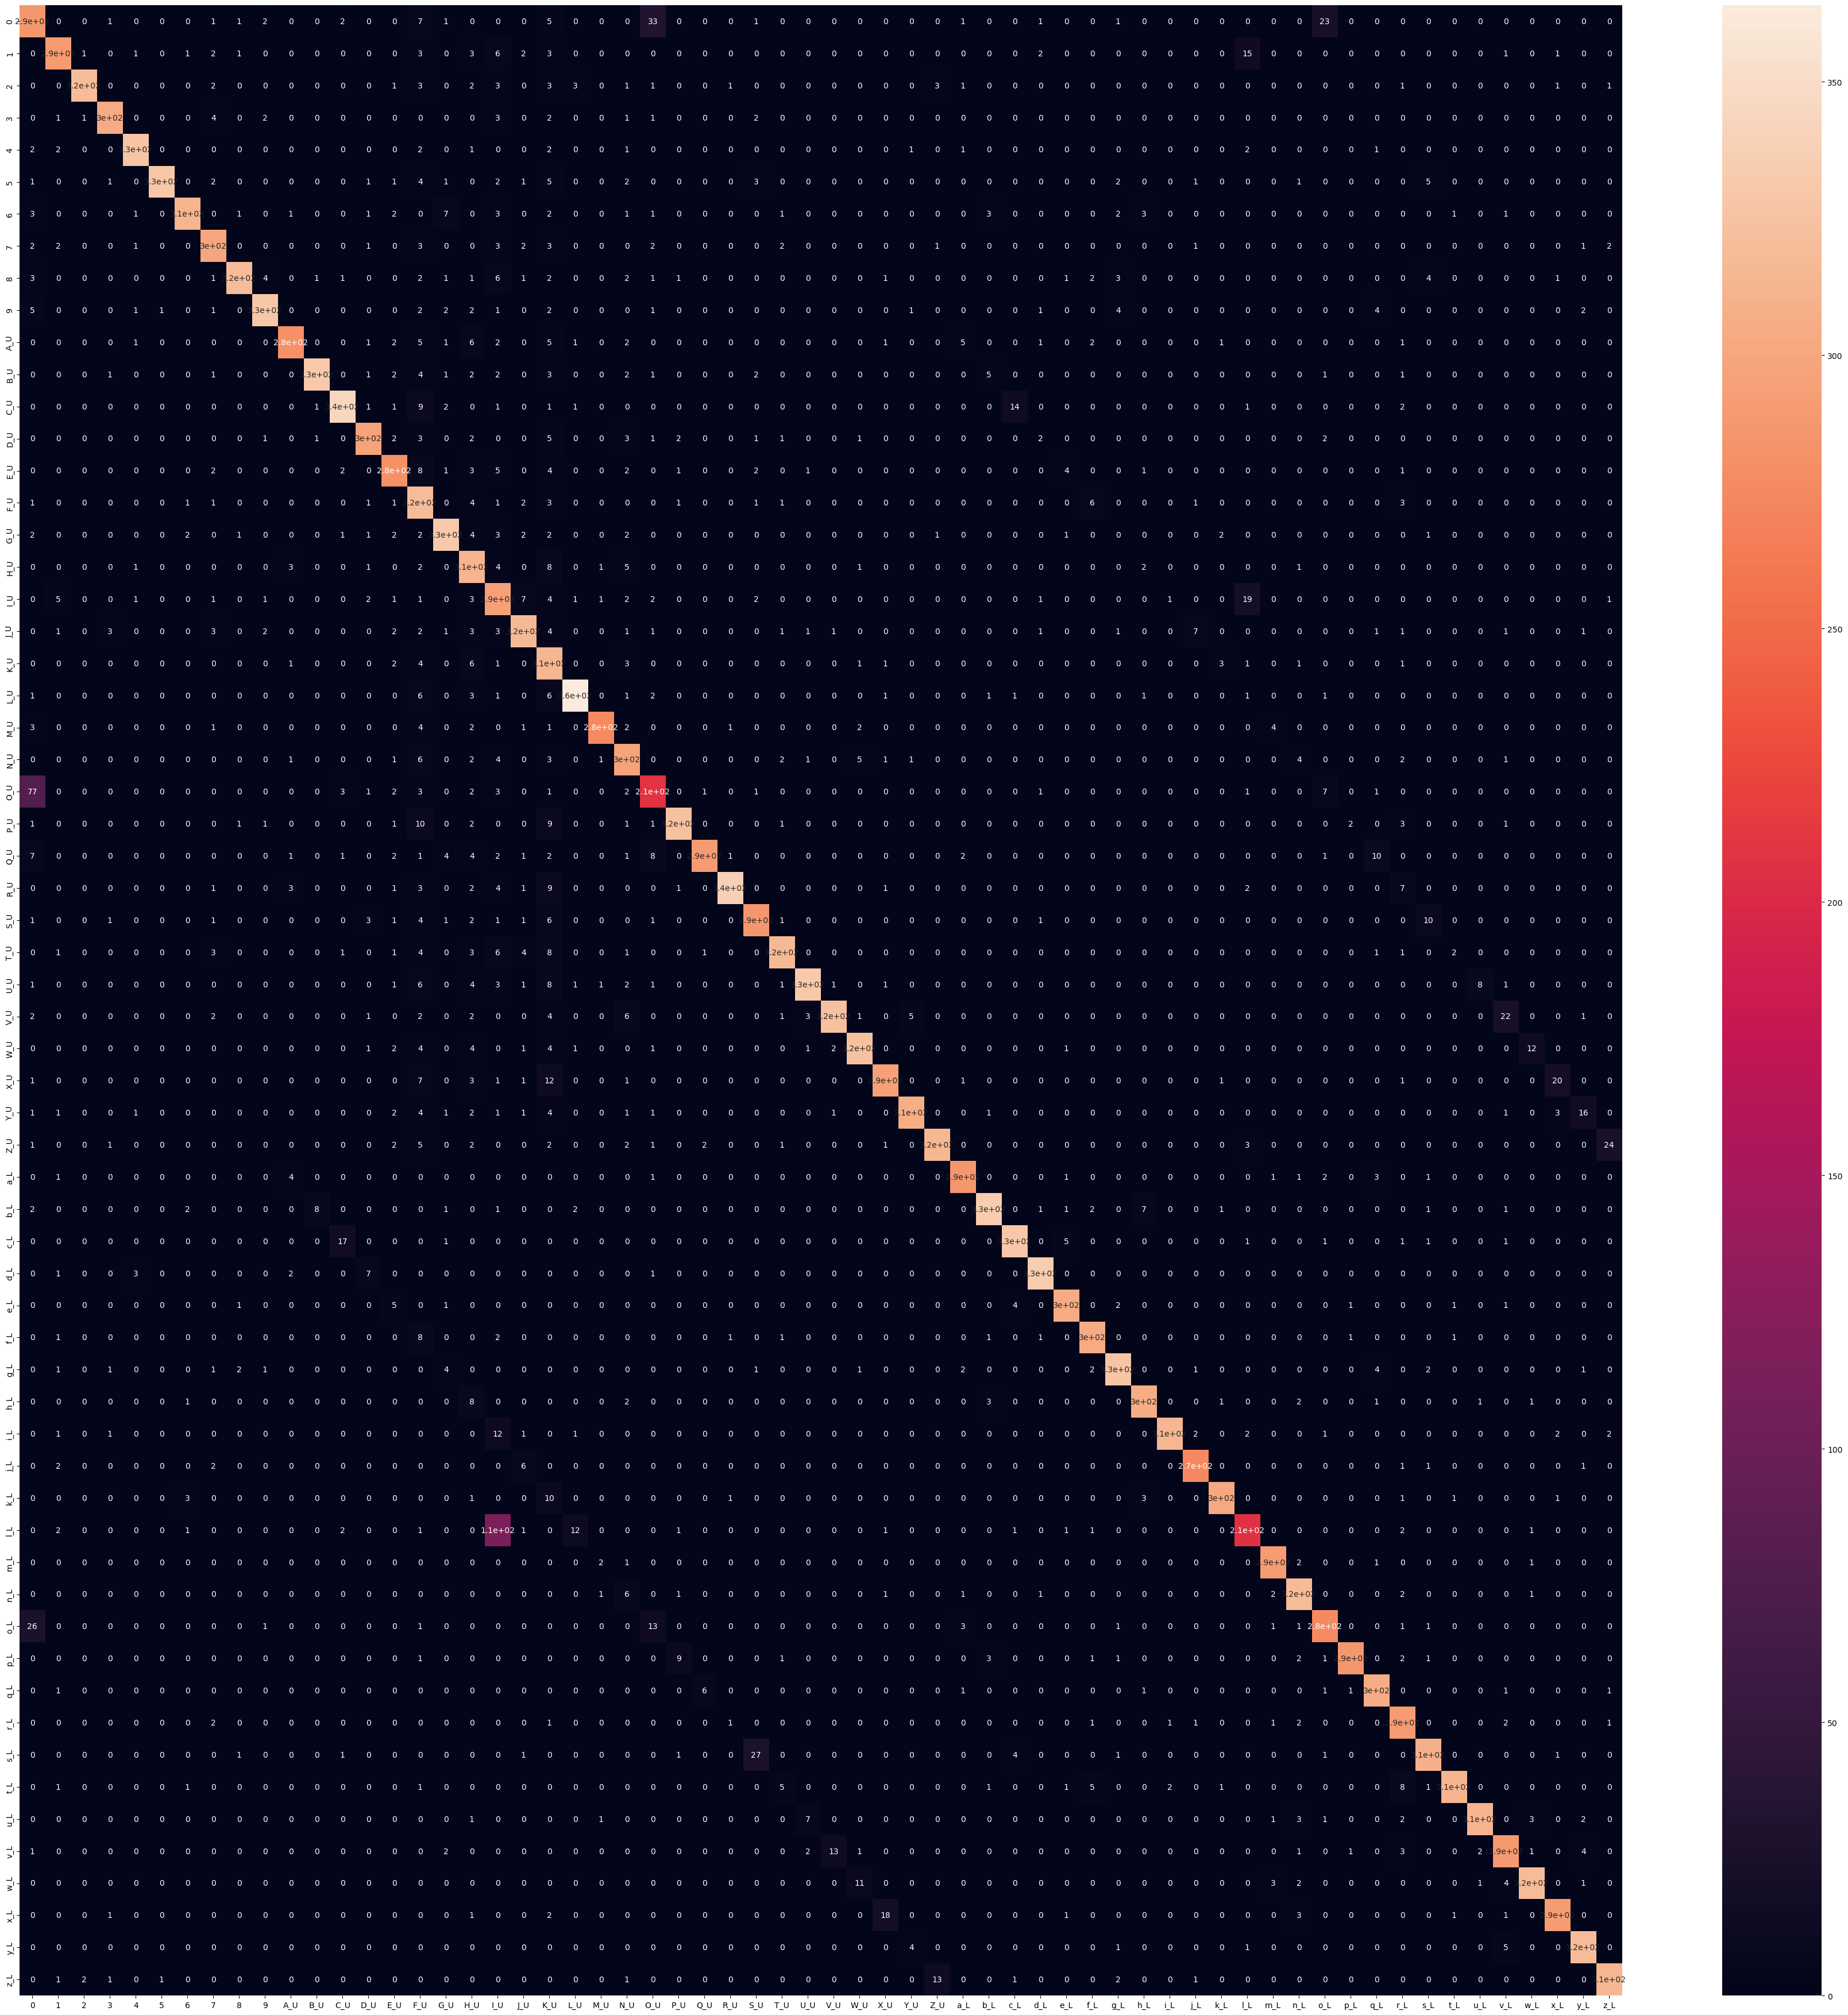

In [101]:
import seaborn as sns
conf_mat = tf.math.confusion_matrix(labels,predictions)
fig, ax = plt.subplots(figsize=(45,45))
sns.heatmap(conf_mat,ax=ax,annot=True)
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.savefig("models/conf_matrix_new.png",dpi=400)